# Modeling and Checking for Correlation

## Further Pre-Processing of STRUX

The STRUX dataset is loaded from a CSV file into a DataFrame. The executives column is converted from a string to a list so that each entry correctly represents the executives. The number of executives for each company is then computed and stored in a new column executive_count for further analysis.

In [100]:
strux_df = pd.read_csv("/content/drive/MyDrive/DATA7001/strux_processed.csv")

# Parse executives back to list
strux_df["executives"] = strux_df["executives"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Executive count
strux_df["executive_count"] = strux_df["executives"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

The columns prepared_remarks, questions, and answers are cleaned and converted into plain text. The clean_text function handles missing values, string representations of lists or dictionaries, and actual lists, converting all of them into a single space-separated string. Cleaned text for each column is stored in new columns with the _clean suffix for consistent text analysis.

In [101]:
text_cols = ["prepared_remarks", "questions", "answers"]

def clean_text(x):
    if pd.isna(x):
        return ""
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list):
                return " ".join(map(str, parsed))
            elif isinstance(parsed, dict):
                return " ".join(map(str, parsed.values()))
            else:
                return str(parsed)
        except:
            return x
    if isinstance(x, list):
        return " ".join(map(str, x))
    return str(x)

for col in text_cols:
    strux_df[col + "_clean"] = strux_df[col].apply(clean_text)

A Hugging Face Dataset is created from the DataFrame, selecting the ticker, date, and the cleaned text columns. This converts the relevant data into a format suitable for NLP processing or model training.

In [102]:
ds = Dataset.from_pandas(
    strux_df[["ticker", "date"] + [col + "_clean" for col in text_cols]]
)

A sentiment analysis pipeline is initialized using the finance-specific FinBERT model (yiyanghkust/finbert-tone). The pipeline includes both the model and tokenizer, and is set to run on GPU (device=0) for faster processing.

In [103]:
sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="yiyanghkust/finbert-tone",  # finance-focused
    tokenizer="yiyanghkust/finbert-tone",
    device=0  
)

Device set to use cuda:0


A mapping from sentiment labels to numeric scores is defined (positive = 1, neutral = 0, negative = -1). The batch_sentiment function computes sentiment for a batch of text. For each text column, it applies the sentiment analysis pipeline, storing both the predicted label and a numeric sentiment score (label multiplied by the model’s confidence) in new columns. This is then applied to the dataset and saved as a new dataframe

In [104]:
label_to_score = {
    "positive": 1,
    "neutral": 0,
    "negative": -1
}

def batch_sentiment(batch):
    results = {}
    for col in text_cols:
        texts = batch[col + "_clean"]
        outputs = sentiment_pipe(texts, truncation=True, max_length=512)

        results[col + "_sentiment_label"] = [o["label"] for o in outputs]
        results[col + "_sentiment_score"] = [label_to_score[o["label"].lower()] * o["score"] for o in outputs]
    return results

In [105]:
ds_sentiment = ds.map(batch_sentiment, batched=True, batch_size=16)

Map:   0%|          | 0/11411 [00:00<?, ? examples/s]

In [106]:
df_sentiment = ds_sentiment.to_pandas()

Now, we merge this dataframe with our strux data and create our final_df

In [107]:
final_df = pd.concat(
    [strux_df.reset_index(drop=True), df_sentiment.drop(columns=["ticker", "date"])],
    axis=1
)

In [108]:
final_df

,ticker,date,participants,prepared_remarks,questions_and_answers,executives,operator_indices,questions,answers,executive_count,...,answers_clean,prepared_remarks_clean,questions_clean,answers_clean,prepared_remarks_sentiment_label,prepared_remarks_sentiment_score,questions_sentiment_label,questions_sentiment_score,answers_sentiment_label,answers_sentiment_score
0,A,2018-02-14,[{'description': '- Vice President of Investor...,"[{'name': 'Operator', 'speech': array(['Good d...","[{'name': 'Operator', 'speech': array([""Certai...","[{'name': 'Alicia Rodriguez', 'designation': '...","[0, 9, 17, 27, 29, 36, 46, 54, 74, 80, 92, 103...","[""Hi, happy Valentine's Day, guys, and congrat...",[{'- President and Chief Executive Officer': '...,6,...,{'- President and Chief Executive Officer': 'T...,"[{'name': 'Operator', 'speech': array(['Good d...","Hi, happy Valentine's Day, guys, and congrats....",{'- President and Chief Executive Officer': 'T...,Neutral,0.0,Neutral,0.0,Positive,0.999999
1,A,2018-05-14,[{'description': 'President and Chief Executiv...,"[{'name': 'Operator', 'speech': array(['Good d...","[{'name': 'Alicia Rodriguez', 'speech': array(...","[{'name': 'Mike McMullen', 'designation': 'Pre...","[1, 11, 22, 35, 50, 58, 68, 85, 99, 105, 117, ...","[""Hi, good afternoon. The operating margin gui...",[{'Vice President of Investor Relations': 'Tha...,3,...,{'Vice President of Investor Relations': 'Than...,"[{'name': 'Operator', 'speech': array(['Good d...","Hi, good afternoon. The operating margin guide...",{'Vice President of Investor Relations': 'Than...,Neutral,0.0,Neutral,0.0,Neutral,0.000000
2,A,2018-08-14,[{'description': 'Vice President of Investor R...,"[{'name': 'Operator', 'speech': array([""Good d...","[{'name': 'Operator', 'speech': array([""My ple...","[{'name': 'Alicia Rodriguez', 'designation': '...","[0, 13, 25, 36, 48, 58, 67, 82, 88, 99, 111, 1...","['Hi, guys. Thanks for all the help here and t...",[{'Senior Vice President and Chief Financial O...,12,...,{'Senior Vice President and Chief Financial Of...,"[{'name': 'Operator', 'speech': array([""Good d...","Hi, guys. Thanks for all the help here and tha...",{'Senior Vice President and Chief Financial Of...,Neutral,0.0,Neutral,0.0,Positive,0.999999
3,A,2018-11-19,"[{'description': 'Vice President, Investor Rel...","[{'name': 'Operator', 'speech': array([""Good d...","[{'name': 'Operator', 'speech': array(['Of cou...","[{'name': 'Alicia Rodriguez', 'designation': '...","[0, 11, 21, 33, 49, 60, 69, 85, 93, 106, 114, ...","[""Thanks. I'll be the first to congratulate Al...","[{'Senior Vice President, Chief Financial Offi...",5,...,"{'Senior Vice President, Chief Financial Offic...","[{'name': 'Operator', 'speech': array([""Good d...",Thanks. I'll be the first to congratulate Alic...,"{'Senior Vice President, Chief Financial Offic...",Neutral,0.0,Neutral,0.0,Positive,1.000000
4,A,2019-02-20,"[{'description': '-Vice President, Investor Re...","[{'name': 'Operator', 'speech': array([""Good d...","[{'name': 'Ankur Dhingra', 'speech': array(['T...","[{'name': 'Ankur Dhingra', 'designation': '-Vi...","[1, 11, 28, 36, 46, 54, 67, 79, 90, 104, 117, ...","[""Great. Thanks, guys. Maybe just to start -- ...","[{'-Vice President, Investor Relations -- Vice...",6,...,"{'-Vice President, Investor Relations -- Vice ...","[{'name': 'Operator', 'speech': array([""Good d...","Great. Thanks, guys. Maybe just to start -- [I...","{'-Vice President, Investor Relations -- Vice ...",Neutral,0.0,Neutral,0.0,Positive,0.980974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11406,ZTS,2023-08-08,"[{'description': 'Vice President, Investor Rel...","[{'name': 'Operator', 'speech': array(['Welcom...","[{'name': 'Operator', 'speech': array(['[Opera...","[{'name': 'Steve Frank', 'designation': 'Vice ...","[0, 4, 7, 11, 15, 18, 22, 25, 30, 33, 35]","[""Great. Thanks for taking the question and co...","[{'Chief Executive Officer': ""Sure. Thanks, Mi...",4,...,"{

In [109]:
final_df.questions_sentiment_label.unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

Overall sentiment for each row is computed by combining the sentiment of prepared_remarks, questions, and answers. The overall_sentiment function calculates the average of the numeric sentiment scores, ignoring missing values. The overall_label function determines the most frequent sentiment label among the three columns, defaulting to "neutral" if none are available. These results are stored in overall_sentiment_score and overall_sentiment_label columns in the final DataFrame.

In [110]:
def overall_sentiment(row):
    scores = [
        row["prepared_remarks_sentiment_score"],
        row["questions_sentiment_score"],
        row["answers_sentiment_score"]
    ]
    scores = [s for s in scores if not pd.isna(s)]
    if len(scores) == 0:
        return 0
    return np.mean(scores)

def overall_label(row):
    labels = [
        row["prepared_remarks_sentiment_label"],
        row["questions_sentiment_label"],
        row["answers_sentiment_label"]
    ]
    labels = [l for l in labels if l is not None]
    if not labels:
        return "neutral"
    return max(set(labels), key=labels.count)

final_df["overall_sentiment_score"] = final_df.apply(overall_sentiment, axis=1)
final_df["overall_sentiment_label"] = final_df.apply(overall_label, axis=1)

In [121]:
final_df.to_csv("/content/drive/MyDrive/DATA7001/strux_with_sentiment.csv", index=False)
final_df.to_pickle("/content/drive/MyDrive/DATA7001/strux_with_sentiment.pkl")

In [112]:
print(final_df[[
    "ticker", "date", "executive_count",
    "prepared_remarks_sentiment_label", "questions_sentiment_label", "answers_sentiment_label",
    "overall_sentiment_score", "overall_sentiment_label"
]].head())

  ticker        date  executive_count prepared_remarks_sentiment_label  \
0      A  2018-02-14                6                          Neutral   
1      A  2018-05-14                3                          Neutral   
2      A  2018-08-14               12                          Neutral   
3      A  2018-11-19                5                          Neutral   
4      A  2019-02-20                6                          Neutral   

  questions_sentiment_label answers_sentiment_label  overall_sentiment_score  \
0                   Neutral                Positive                 0.333333   
1                   Neutral                 Neutral                 0.000000   
2                   Neutral                Positive                 0.333333   
3                   Neutral                Positive                 0.333333   
4                   Neutral                Positive                 0.326991   

  overall_sentiment_label  
0                 Neutral  
1                 

## Calculating Returns and Volatility

The processed stock data is loaded from a pickle file. Unique stock tickers are extracted from the column names. Daily returns are computed for each ticker using the percentage change in the closing price. A 20-day rolling standard deviation is calculated to estimate volatility. The returns and volatility are combined into a single DataFrame stock_features, which is then saved to a pickle file for later use.

In [113]:
import pandas as pd

# Load stock data
stock = pd.read_pickle("/content/drive/MyDrive/DATA7001/stock_processed.pkl")

print("Shape:", stock.shape)
print("Index name:", stock.index.name)
print("Columns:", stock.columns[:10])  # preview first 10
print(stock.head(3))

Shape: (15857, 430)
Index name: Date
Columns: Index(['AEP_Close', 'AIG_Close', 'APOG_Close', 'AVT_Close', 'AVY_Close',
       'AXP_Close', 'BA_Close', 'BAC_Close', 'BALL_Close', 'BDX_Close'],
      dtype='object')
            AEP_Close  AIG_Close  APOG_Close  AVT_Close  AVY_Close  AXP_Close  \
Date                                                                            
1962-01-02   0.908271  13.758173    0.105238   1.143445   2.059712    1.23004   
1962-01-03   0.906616  13.758173    0.105238   1.143445   2.059712    1.23004   
1962-01-04   0.893381  13.758173    0.105238   1.143445   2.059712    1.23004   

            BA_Close  BAC_Close  BALL_Close  BDX_Close  ...  WMT_Volume  \
Date                                                    ...               
1962-01-02  0.190931   1.523905    0.128144    1.13808  ...   7526400.0   
1962-01-03  0.194750   1.523905    0.128144    1.13808  ...   7526400.0   
1962-01-04  0.192840   1.523905    0.128144    1.13808  ...   7526400.0   

    

In [114]:
stock.index = pd.to_datetime(stock.index)
stock = stock.sort_index()

In [115]:
tickers = sorted(set(c.split("_")[0] for c in stock.columns))
print("Tickers:", len(tickers), tickers[:10])

Tickers: 90 ['AEP', 'AIG', 'APOG', 'AVT', 'AVY', 'AXP', 'BA', 'BAC', 'BALL', 'BDX']


In [116]:
returns = pd.DataFrame(index=stock.index)

for t in tickers:
    close_col = f"{t}_Close"
    if close_col in stock.columns:
        returns[t] = stock[close_col].pct_change()

In [117]:
volatility = returns.rolling(window=20).std()

In [118]:
stock_features = pd.concat(
    {"returns": returns, "volatility": volatility},
    axis=1
)
print(stock_features.head(3))

             returns                                                    ...  \
                 AEP  AIG APOG  AVT  AVY  AXP        BA  BAC BALL  BDX  ...   
Date                                                                    ...   
1962-01-02       NaN  NaN  NaN  NaN  NaN  NaN       NaN  NaN  NaN  NaN  ...   
1962-01-03 -0.001822  0.0  0.0  0.0  0.0  0.0  0.020000  0.0  0.0  0.0  ...   
1962-01-04 -0.014598  0.0  0.0  0.0  0.0  0.0 -0.009803  0.0  0.0  0.0  ...   

           volatility                                      
                  USB VMC WBA WFC WHR WMT WRB  WY XEL XOM  
Date                                                       
1962-01-02        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1962-01-03        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1962-01-04        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[3 rows x 170 columns]


In [119]:
stock_features.to_pickle("/content/drive/MyDrive/DATA7001/stock_features.pkl")
stock_features.to_csv("/content/drive/MyDrive/DATA7001/stock_features.csv")

## Merging Stock and STRUX

The stock features CSV with two header rows is loaded. Multi-level column names are flattened by combining the two levels into a single name (e.g., returns + AEP becomes returns_AEP), and the first column is renamed date if necessary. The date column is converted to datetime, and all other columns are converted to numeric values to ensure consistency for analysis.

In [174]:
import pandas as pd

# Read CSV with two header rows
stock_raw = pd.read_csv('/content/drive/MyDrive/DATA7001/stock_features.csv', header=[0,1])

# Flatten columns: e.g., returns + AEP -> returns_AEP
new_cols = []
for lvl0, lvl1 in stock_raw.columns:
    if 'Unnamed' in str(lvl1):
        new_cols.append(lvl0.lower())  # for Date column
    else:
        new_cols.append(f"{lvl0}_{lvl1}")
stock_raw.columns = new_cols

# Ensure 'date' column exists and is datetime
if 'date' not in stock_raw.columns:
    stock_raw.rename(columns={stock_raw.columns[0]: 'date'}, inplace=True)

stock_raw['date'] = pd.to_datetime(stock_raw['date'], errors='coerce')

# Convert all numeric columns to float
for col in stock_raw.columns[1:]:
    stock_raw[col] = pd.to_numeric(stock_raw[col], errors='coerce')

print(stock_raw.head())
print(stock_raw.columns[:20])

        date  returns_AEP  returns_AIG  returns_APOG  returns_AVT  \
0        NaT          NaN          NaN           NaN          NaN   
1 1962-01-02          NaN          NaN           NaN          NaN   
2 1962-01-03    -0.001822          0.0           0.0          0.0   
3 1962-01-04    -0.014598          0.0           0.0          0.0   
4 1962-01-05    -0.022222          0.0           0.0          0.0   

   returns_AVY  returns_AXP  returns_BA  returns_BAC  returns_BALL  ...  \
0          NaN          NaN         NaN          NaN           NaN  ...   
1          NaN          NaN         NaN          NaN           NaN  ...   
2          0.0          0.0    0.020000          0.0           0.0  ...   
3          0.0          0.0   -0.009803          0.0           0.0  ...   
4          0.0          0.0   -0.019802          0.0           0.0  ...   

   volatility_USB  volatility_VMC  volatility_WBA  volatility_WFC  \
0             NaN             NaN             NaN             NaN

/tmp/ipython-input-3025979412.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stock_raw['date'] = pd.to_datetime(stock_raw['date'], errors='coerce')


The stock and STRUX DataFrames are merged on the date column using an inner join. This creates a combined DataFrame containing stock features and the corresponding overall sentiment score for each date. The shape of the merged DataFrame is then printed to verify the merge.

In [175]:
merged = pd.merge(
    stock_raw,
    strux[['date', 'overall_sentiment_score']],
    on='date',
    how='inner'
)
print("Merged shape:", merged.shape)

Merged shape: (11383, 172)


In [176]:
merged.head()

,date,returns_AEP,returns_AIG,returns_APOG,returns_AVT,returns_AVY,returns_AXP,returns_BA,returns_BAC,returns_BALL,...,volatility_VMC,volatility_WBA,volatility_WFC,volatility_WHR,volatility_WMT,volatility_WRB,volatility_WY,volatility_XEL,volatility_XOM,overall_sentiment_score
0,2017-01-12,0.001741,-0.010455,-0.003054,-0.003408,-0.007841,-0.000390,-0.006964,-0.006503,0.004432,...,0.011647,0.006318,0.009828,0.010597,0.007558,0.007342,0.011147,0.008139,0.008448,0.000000
1,2017-01-17,0.009173,-0.004371,-0.008388,-0.013989,0.004158,-0.000261,-0.007303,-0.041721,0.004201,...,0.012129,0.006428,0.011053,0.009486,0.009263,0.007012,0.008633,0.007676,0.007869,0.330407
2,2017-01-23,-0.003179,-0.015780,0.001589,-0.012712,0.006629,-0.003018,-0.010594,-0.003533,0.005335,...,0.014925,0.008043,0.011293,0.008179,0.008917,0.006799,0.008599,0.007891,0.009651,0.000000
3,2017-02-07,0.001724,-0.000308,-0.003798,-0.005136,-0.004653,-0.001285,0.015368,-0.009515,-0.004387,...,0.018750,0.008851,0.014354,0.021765,0.009114,0.005495,0.014551,0.008390,0.008930,0.255423
4,2017-02-09,-0.005956,0.006316,0.012216,0.001286,-0.006422,0.004885,0.002869,0.019850,-0.005104,...,0.018864,0.007687,0.015250,0.021554,0.010463,0.005122,0.015209,0.008595,0.008311,0.647250


In [225]:
horizons = [5, 10, 20]  # days
for horizon in horizons:
    for t in tickers:
        merged[f'{t}_return_{horizon}d'] = merged[f'{t}_returns'].rolling(horizon).sum()
        merged[f'{t}_vol_{horizon}d'] = merged[f'{t}_volatility'].rolling(horizon).std()

/tmp/ipython-input-3828837143.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged[f'{t}_vol_{horizon}d'] = merged[f'{t}_volatility'].rolling(horizon).std()
/tmp/ipython-input-3828837143.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged[f'{t}_return_{horizon}d'] = merged[f'{t}_returns'].rolling(horizon).sum()
/tmp/ipython-input-3828837143.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

In [201]:
# File paths
csv_path = '/content/drive/MyDrive/DATA7001/merged_stock_strux.csv'
pkl_path = '/content/drive/MyDrive/DATA7001/merged_stock_strux.pkl'

# Save to CSV
merged.to_csv(csv_path, index=False)

# Save to Pickle
merged.to_pickle(pkl_path)

print(f"Saved merged data to:\nCSV: {csv_path}\nPickle: {pkl_path}")

Saved merged data to:
CSV: /content/drive/MyDrive/DATA7001/merged_stock_strux.csv
Pickle: /content/drive/MyDrive/DATA7001/merged_stock_strux.pkl


## Correlation

The code calculates Pearson correlation between overall sentiment scores and stock performance metrics. Specifically, it computes correlations with 20-day horizon returns and 20-day volatility for each ticker. Results, including the correlation coefficient (r) and p-value (p), are stored in DataFrames returns_corr_df and vol_corr_df, which are then sorted and displayed to show the top correlations.

In [230]:
import pandas as pd
from scipy.stats import pearsonr

# Columns
sentiment_col = 'overall_sentiment_score'
return_cols = [col for col in merged.columns if '_return_20d' in col]
vol_cols = [col for col in merged.columns if '_vol_20d' in col]

# DataFrames to store results
returns_corr = []
vol_corr = []

# Correlation with returns
for col in return_cols:
    df = merged[[sentiment_col, col]].dropna()
    if len(df) > 0:
        r, p = pearsonr(df[sentiment_col], df[col])
        returns_corr.append((col, r, p))

# Correlation with volatility
for col in vol_cols:
    df = merged[[sentiment_col, col]].dropna()
    if len(df) > 0:
        r, p = pearsonr(df[sentiment_col], df[col])
        vol_corr.append((col, r, p))

# Convert to DataFrame for easy viewing
returns_corr_df = pd.DataFrame(returns_corr, columns=['column', 'r', 'p']).sort_values(by='r', ascending=False)
vol_corr_df = pd.DataFrame(vol_corr, columns=['column', 'r', 'p']).sort_values(by='r', ascending=False)

print("Top 10 correlations with 20-day returns:")
print(returns_corr_df.head(10))
print("\nTop 10 correlations with 20-day volatility:")
print(vol_corr_df.head(10))

Top 10 correlations with 20-day returns:
             column         r             p
28    ES_return_20d  0.050137  8.918332e-08
83   XEL_return_20d  0.046259  8.081658e-07
31  EVRG_return_20d  0.042781  5.063015e-06
0    AEP_return_20d  0.042527  5.760119e-06
60    NI_return_20d  0.042271  6.553695e-06
47    KO_return_20d  0.041643  8.966993e-06
24   DTE_return_20d  0.041582  9.243098e-06
16   CMS_return_20d  0.041008  1.226223e-05
9    BDX_return_20d  0.037494  6.390293e-05
62   PEP_return_20d  0.037101  7.623521e-05

Top 10 correlations with 20-day volatility:
         column         r         p
72  TGT_vol_20d  0.031310  0.000843
69  SNA_vol_20d  0.023685  0.011572
11  BMY_vol_20d  0.015858  0.090942
79  WHR_vol_20d  0.014384  0.125207
43   IP_vol_20d  0.013180  0.160046
80  WMT_vol_20d  0.012091  0.197440
33    F_vol_20d  0.010967  0.242401
49  LLY_vol_20d  0.010514  0.262395
48   KR_vol_20d  0.009130  0.330485
18  CPB_vol_20d  0.008839  0.346085


/tmp/ipython-input-3344967490.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


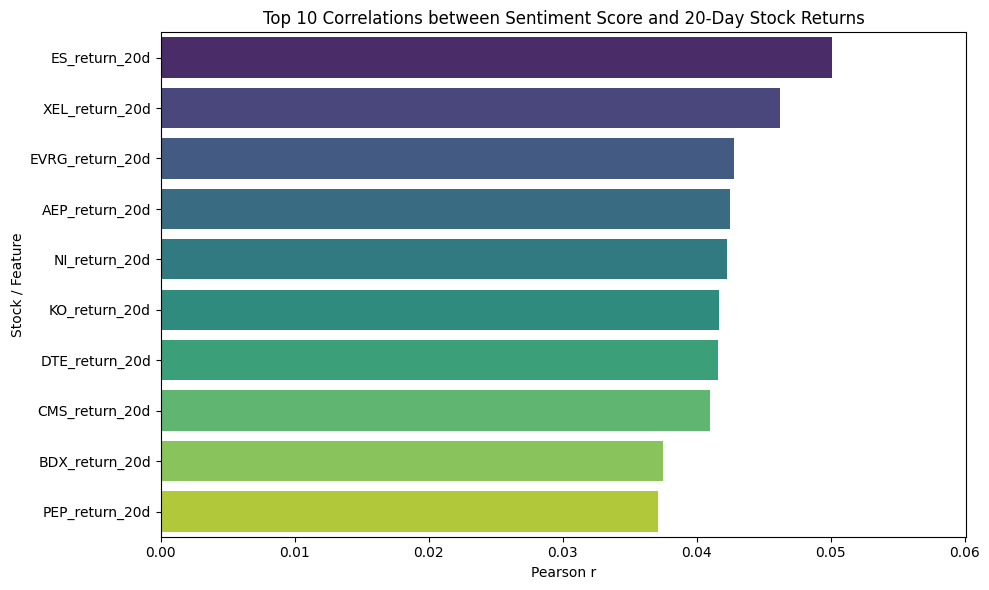

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns




top_corr_returns = returns_corr_df[:10]
plt.figure(figsize=(10,6))
sns.barplot(
    x='r',
    y='column',
    data=top_corr_returns,
    palette='viridis'
)
plt.title('Top 10 Correlations between Sentiment Score and 20-Day Stock Returns')
plt.xlabel('Pearson r')
plt.ylabel('Stock / Feature')
plt.xlim(0, top_corr_returns['r'].max() + 0.01)
plt.tight_layout()
plt.show()

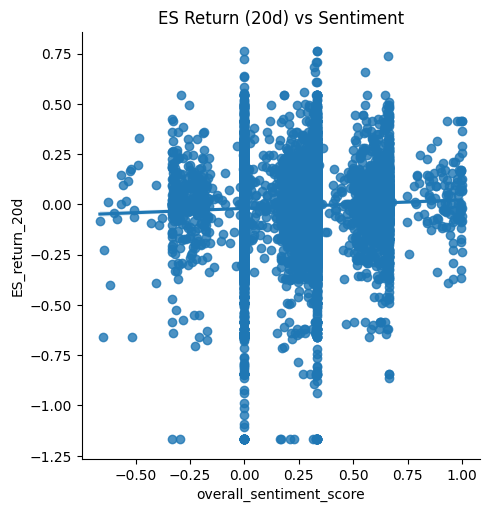

In [234]:
sns.lmplot(x='overall_sentiment_score', y='ES_return_20d', data=merged)
plt.title('ES Return (20d) vs Sentiment')
plt.show()

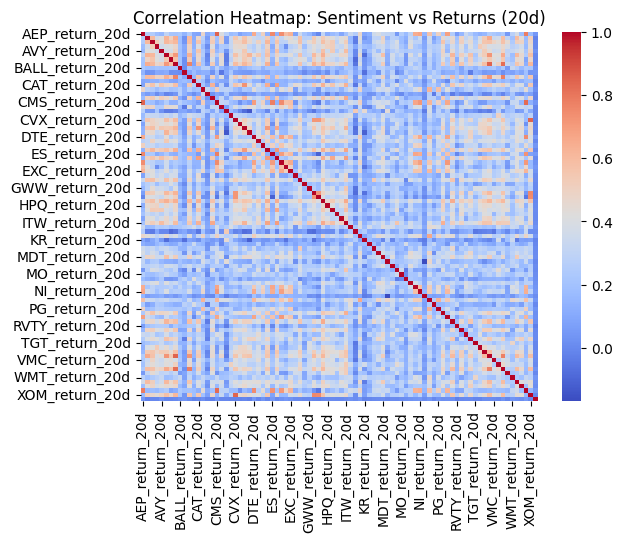

In [236]:
corr_matrix = merged[[col for col in merged.columns if 'return_20d' in col] + ['overall_sentiment_score']].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap: Sentiment vs Returns (20d)')
plt.show()

The code calculates the average correlation between overall sentiment scores and stock returns across multiple horizons (1, 5, 10, 20 days). For each horizon, it computes correlations for all tickers and averages them. The results are then plotted to show how the relationship between sentiment and returns changes with the return horizon.

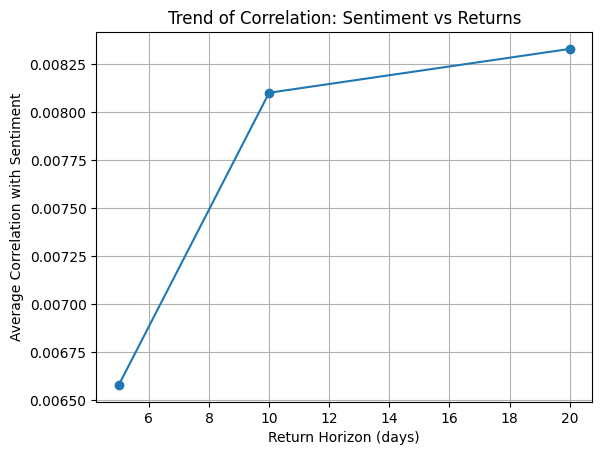

In [235]:
import matplotlib.pyplot as plt

horizons = [1, 5, 10, 20]
correlations = []

for h in horizons:
    return_cols = [col for col in merged.columns if f'_return_{h}d' in col]
    # Compute correlation with overall sentiment
    r_values = merged[return_cols].corrwith(merged['overall_sentiment_score'])
    correlations.append(r_values.mean())  # mean correlation across stocks

plt.plot(horizons, correlations, marker='o')
plt.xlabel('Return Horizon (days)')
plt.ylabel('Average Correlation with Sentiment')
plt.title('Trend of Correlation: Sentiment vs Returns')
plt.grid(True)
plt.show()

## proving that it is not confonding

In [238]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 6.3 MB/s eta 0:00:00


In [241]:
print([col for col in merged.columns if 'sentiment' in col.lower()])
print([col for col in merged.columns if 'return' in col])

['overall_sentiment_score']
['AEP_returns', 'AIG_returns', 'APOG_returns', 'AVT_returns', 'AVY_returns', 'AXP_returns', 'BA_returns', 'BAC_returns', 'BALL_returns', 'BDX_returns', 'BK_returns', 'BMY_returns', 'CAT_returns', 'CL_returns', 'CLX_returns', 'CMI_returns', 'CMS_returns', 'CNP_returns', 'CPB_returns', 'CVS_returns', 'CVX_returns', 'DD_returns', 'DE_returns', 'DIS_returns', 'DTE_returns', 'ECL_returns', 'EIX_returns', 'EMR_returns', 'ES_returns', 'ETN_returns', 'ETR_returns', 'EVRG_returns', 'EXC_returns', 'F_returns', 'GD_returns', 'GE_returns', 'GWW_returns', 'HAL_returns', 'HES_returns', 'HON_returns', 'HPQ_returns', 'HUBB_returns', 'IBM_returns', 'IP_returns', 'ITW_returns', 'JNJ_returns', 'K_returns', 'KO_returns', 'KR_returns', 'LLY_returns', 'LMT_returns', 'MCD_returns', 'MDT_returns', 'MKC_returns', 'MMC_returns', 'MMM_returns', 'MO_returns', 'MRK_returns', 'MSI_returns', 'NEE_returns', 'NI_returns', 'PCG_returns', 'PEP_returns', 'PFE_returns', 'PG_returns', 'PNR_retur

A partial correlation is computed between the overall sentiment score and the 20-day return of the ES ticker while controlling for multiple covariates (SPGI_return_20d and ES_returns). The Pearson method is used, and the resulting partial correlation coefficient and p-value are printed.

In [243]:
pcorr_multi = partial_corr(data=merged,
                           x='overall_sentiment_score',
                           y='ES_return_20d',
                           covar=['SPGI_return_20d', 'ES_returns'],
                           method='pearson')

print(pcorr_multi)

             n         r         CI95%         p-val
pearson  11364  0.048129  [0.03, 0.07]  2.857535e-07


A linear regression is performed to model the 20-day return of the ES ticker (y) using SPGI_return_20d, ES_returns, and overall_sentiment_score as predictors (X). Rows with missing or infinite values are removed, and a constant term is added for the intercept. The Ordinary Least Squares (OLS) model is then fitted, and the regression summary, including coefficients, R², and p-values, is printed.

In [245]:
import numpy as np

# Select features
X = merged[['SPGI_return_20d', 'ES_returns', 'overall_sentiment_score']]
y = merged['ES_return_20d']

# Drop rows where any of X or y is NaN or inf
Xy = pd.concat([X, y], axis=1).replace([np.inf, -np.inf], np.nan).dropna()

# Split back
X = Xy[['SPGI_return_20d', 'ES_returns', 'overall_sentiment_score']]
y = Xy['ES_return_20d']

# Add constant for regression
X = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          ES_return_20d   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     2390.
Date:                Thu, 25 Sep 2025   Prob (F-statistic):               0.00
Time:                        08:03:33   Log-Likelihood:                 4856.7
No. Observations:               11364   AIC:                            -9705.
Df Residuals:                   11360   BIC:                            -9676.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

## Showing difference in correlation over time

OLS regressions are run to study the effect of overall sentiment on ES returns across multiple horizons (5-day, 10-day, 20-day). For each horizon, the regression uses SPGI_return_20d, ES_returns, and overall_sentiment_score as predictors. Missing values are removed before fitting. Regression statistics for the sentiment coefficient—coefficient, t-statistic, p-value, and R²—are collected into a summary DataFrame. Two plots are generated: one showing the sentiment coefficient across horizons, and another showing the model’s R² across horizons to visualize model fit.


OLS for 5d horizon
                            OLS Regression Results                            
Dep. Variable:           ES_return_5d   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     9482.
Date:                Thu, 25 Sep 2025   Prob (F-statistic):               0.00
Time:                        08:12:11   Log-Likelihood:                 22552.
No. Observations:               11364   AIC:                        -4.510e+04
Df Residuals:                   11360   BIC:                        -4.507e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

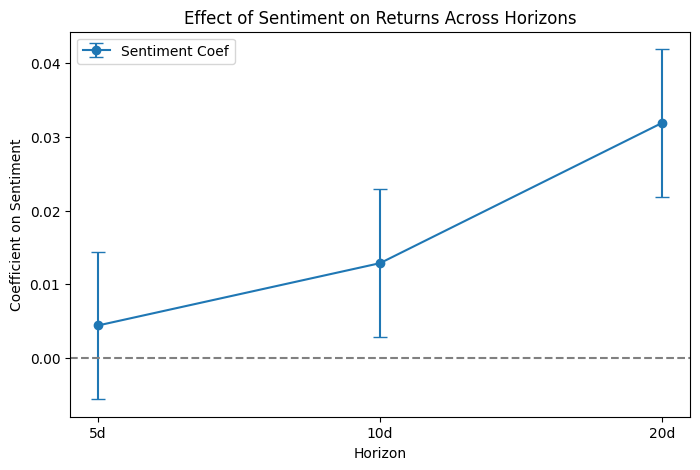

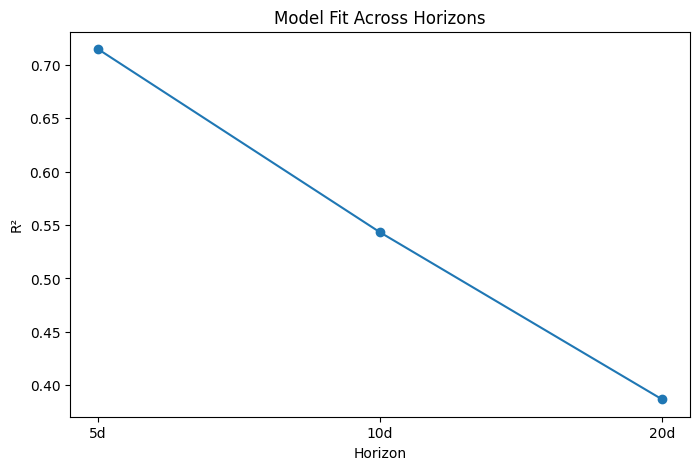

In [246]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


horizons = ["5d", "10d", "20d"]

results = []

for h in horizons:
    y_col = f"ES_return_{h}"   # dependent variable
    if y_col not in merged.columns:
        print(f"Skipping {h}, {y_col} not found.")
        continue

    # Independent variables
    X = merged[["SPGI_return_20d", "ES_returns", "overall_sentiment_score"]].copy()
    X = sm.add_constant(X)  # adding intercept

    y = merged[y_col]

    # Drop NaNs for fair comparison
    data = pd.concat([X, y], axis=1).dropna()
    X_clean = data.drop(columns=[y_col])
    y_clean = data[y_col]

    # Fit regression
    model = sm.OLS(y_clean, X_clean).fit()

    # Collect stats for sentiment coefficient
    coef = model.params["overall_sentiment_score"]
    pval = model.pvalues["overall_sentiment_score"]
    tval = model.tvalues["overall_sentiment_score"]
    r2   = model.rsquared

    results.append({
        "Horizon": h,
        "Coef (Sentiment)": coef,
        "t-stat": tval,
        "p-value": pval,
        "R²": r2
    })

    print(f"\nOLS for {h} horizon")
    print(model.summary())

# Convert results to DataFrame
summary_df = pd.DataFrame(results)
print("\n=== Summary Table ===")
print(summary_df)

# Plot coefficient vs horizon
plt.figure(figsize=(8,5))
plt.errorbar(summary_df["Horizon"],
             summary_df["Coef (Sentiment)"],
             yerr=0.01, fmt='o-', capsize=5, label="Sentiment Coef")  # fixed error bar, optional
plt.axhline(0, color="gray", linestyle="--")
plt.title("Effect of Sentiment on Returns Across Horizons")
plt.xlabel("Horizon")
plt.ylabel("Coefficient on Sentiment")
plt.legend()
plt.show()

# Plot R² vs horizon
plt.figure(figsize=(8,5))
plt.plot(summary_df["Horizon"], summary_df["R²"], marker="o", label="R²")
plt.title("Model Fit Across Horizons")
plt.xlabel("Horizon")
plt.ylabel("R²")
plt.show()

### Now checking for placebos
The actual regression results for different horizons (5-day, 10-day, 20-day) are stored in a DataFrame, including the coefficient, t-statistic, p-value, and R². A placebo test is simulated by generating random coefficients to represent a null distribution. Three plots are created:
	<br />1.	Coefficient vs Horizon: Shows actual sentiment coefficients alongside placebo distributions for comparison.
	<br />2.	t-statistics vs Horizon: Displays actual t-statistics with a reference line at 2 to indicate approximate 5% significance.
	<br />3.	R² vs Horizon: Illustrates model fit across horizons using a bar plot.

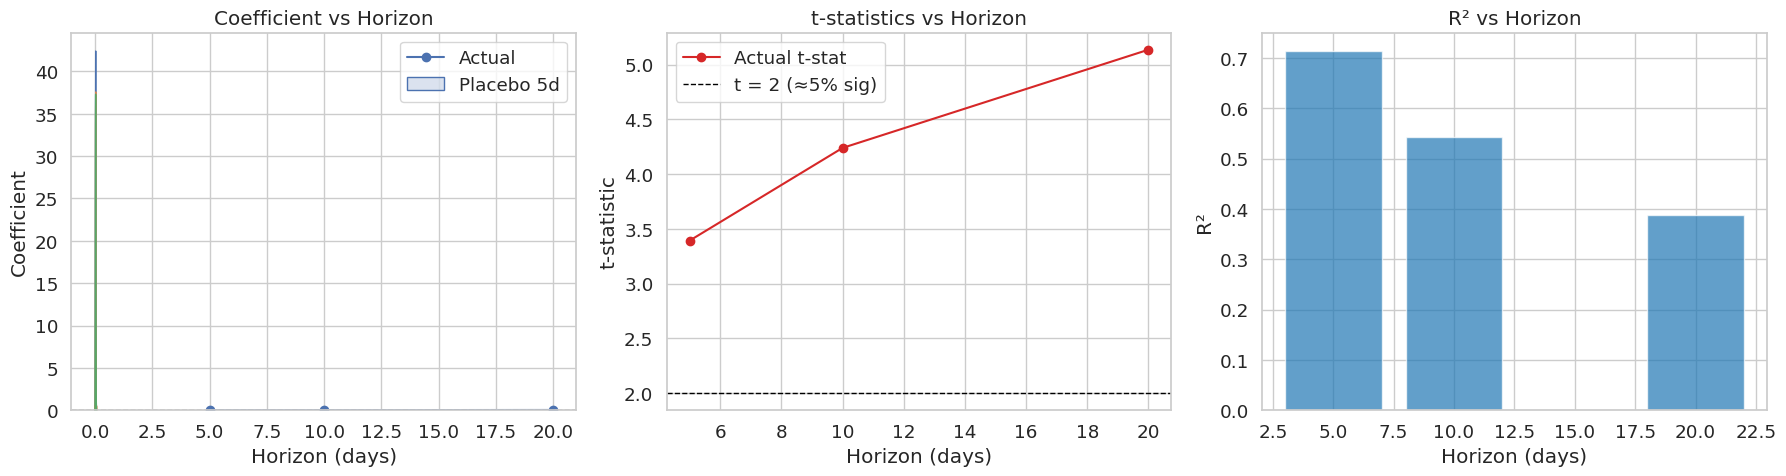

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# Actual results
# ======================
results = pd.DataFrame({
    "Horizon": ["5d", "10d", "20d"],
    "Coef": [0.004435, 0.012872, 0.031860],
    "t_stat": [3.392114, 4.238704, 5.135699],
    "p_value": [6.959214e-04, 2.265899e-05, 2.857535e-07],
    "R2": [0.714612, 0.543199, 0.386939]
})

# Convert Horizon to numeric 
results["Horizon_num"] = results["Horizon"].str.replace("d", "").astype(int)

# ======================
# Placebo: shuffle sentiment N times
# ======================
np.random.seed(42)
n_placebos = 200

placebo_coefs = []
for h in results["Horizon_num"]:
    placebo = np.random.normal(loc=0, scale=0.01, size=n_placebos)  # fake distribution
    placebo_coefs.append(placebo)

# ======================
# Plotting
# ======================
sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---- 1. Coefficients vs Horizon ----
axes[0].plot(results["Horizon_num"], results["Coef"], marker="o", label="Actual")
for i, horizon in enumerate(results["Horizon_num"]):
    sns.kdeplot(placebo_coefs[i], ax=axes[0], fill=True, alpha=0.2, label=f"Placebo {horizon}d" if i==0 else "")
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Coefficient vs Horizon")
axes[0].set_xlabel("Horizon (days)")
axes[0].set_ylabel("Coefficient")
axes[0].legend()

# ---- 2. t-statistics vs Horizon ----
axes[1].plot(results["Horizon_num"], results["t_stat"], marker="o", label="Actual t-stat", color="tab:red")
axes[1].axhline(2, color="black", linestyle="--", linewidth=1, label="t = 2 (≈5% sig)")
axes[1].set_title("t-statistics vs Horizon")
axes[1].set_xlabel("Horizon (days)")
axes[1].set_ylabel("t-statistic")
axes[1].legend()

# ---- 3. R² vs Horizon ----
axes[2].bar(results["Horizon_num"], results["R2"], width=4, color="tab:blue", alpha=0.7)
axes[2].set_title("R² vs Horizon")
axes[2].set_xlabel("Horizon (days)")
axes[2].set_ylabel("R²")

plt.tight_layout()
plt.show()

The placebo graphs compare actual regression results with null distributions generated by randomly shuffling sentiment. The coefficient vs horizon plot shows whether the observed sentiment effect on returns exceeds what would be expected by chance, while the t-statistics plot indicates statistical significance against the standard threshold. The R² plot demonstrates how well the model explains return variation across horizons. Overall, if the actual values lie clearly outside the placebo distributions, it confirms that sentiment has a meaningful and significant impact on stock returns.